# Démonstration 5: Classifieur de Bayes. Maximum de Vraisemblance pour une densité Gaussienne multivariée. 03/10

## Préface

Commencez, si nécessaire, par vous rappeler les notes du cours sur le [classifieur de Bayes](https://studium.umontreal.ca/pluginfile.php/2636322/mod_resource/content/3/7_classifieur_bayes.pdf) et le principe de [maximum de vraisemblance](https://studium.umontreal.ca/pluginfile.php/2636388/mod_resource/content/1/maxvraisemblancegaussienne.pdf).



## Description de haut niveau

Aujourd'hui on va construire un **classifieur multiclasse de Bayes**. Ça veut dire qu'au lieu de modéliser $p(\mbox{classe}|\mbox{exemple})$ (ou $p(y|x)$), on va plutôt utiliser l'équation de Bayes 

$$p(\mbox{classe}|\mbox{exemple}) = \frac{p(\mbox{exemple}|\mbox{classe})p(\mbox{classe})}{\sum_{c'=1}^{m}p_\mbox{c'}(x)P_\mbox{c'}}$$

et modéliser les différents morceaux. En fait, on a juste besoin de modéliser le numérateur puisque le dénominateur est une constante de normalisation. De plus, $ P_\mbox{c'} = n_c / n $

Le terme $p(\mbox{classe})$ représente la probabilité à priori d'une classe, c'est-à-dire notre croyance à priori - avant d'avoir vu un exemple en particulier - sur la probabilité qu'un exemple inconnu appartienne à cette classe). On va représenter cette croyance à priori pour une classe par la fréquence de cette dernière dans les données d'entraînement: $\frac{n_c}{n}$ où $n_c$ = nombre d'exemple de la classe $c$, puis $n$ = nombre d'exemple d'entraînement. 

On va utiliser des **densités Gaussiennes multivariées** pour modéliser les différents $p(\mbox{exemple}|\mbox{classe})$. Cela veut dire que pour chaque classe, on va supposer que la "vrai" distribution $p(\mbox{exemple}|\mbox{classe})$ possède la forme d'une Gaussienne multivariée dont on va tenter d'apprendre les paramètres $\mu$ et $\Sigma$. En pratique, on va se limiter aujourd'hui à un cas particulier de cette distribution: celui où l'on suppose que la matrice de covariance $\Sigma$ de chaque Gaussienne est diagonale et que chaque élément de cette diagonale est le même, soit sigma_sq ( <=> "sigma square" <=> $\sigma^2$ <=> la variance). On possède donc un seul paramètre pour contrôler la forme de la covariance. C'est plus simple (pour nous et pour l'ordinateur) à calculer, mais ça signifie aussi que notre modèle est moins puissant. 

On a donc un modèle paramétrique très simple. Les paramètres sont la moyenne $\mu$ (un vecteur de dimension celle de l'entrée du système) et la variance $\sigma^2$ (un seul scalaire dans notre modèle simple, qui va multiplier la matrice identité). L'apprentissage dans ce modèle se fera aujourd'hui par l'application du **principe de maximum de vraisemblance**. Pour chaque classe, on va trouver les valeurs des paramètres qui maximisent la log-vraisemblance des données d'entraînement issus de cette classe: 

$$\log\prod_i^n p(X=x_i)$$

Voici le [détail du calcul](https://studium.umontreal.ca/mod/resource/view.php?id=416973) par maximum de vraisemblance de $\mu$ et $\sigma^2$ dans le cas qui nous intéresse, soit une gaussienne isotropique.

Ayant trouvé les paramètres qui maximisent la vraisemblance pour chacune des classes, il nous est possible de calculer tous les $p(\mbox{exemple}|\mbox{classe})$. Il suffit maintenant d'appliquer la règle de Bayes afin de pouvoir classifier un nouvel exemple. Plus précisément, on voudra choisir, pour un exemple, la classe qui maximise $p(\mbox{exemple}|\mbox{classe})p(\mbox{classe})$ ou encore $log(p(\mbox{exemple}|\mbox{classe})p(\mbox{classe}))$.


## Code à compléter

Chargez le fichier [utilitaires.py](https://studium.umontreal.ca/mod/resource/view.php?id=459041) dans le dossier où se trouve vos fichier notebook. Il contient les fonctions utiles que vous avez vus au dernier cours. Vous pourez ainsi les utiliser sans qu'elles encombre votre notebook.



 Pour la classe `gauss_mv`:
 
 - calculez sigma_sq ($\sigma^2$), la variance dans `gauss_mv.train`
 - calculez la valeur de la fonction de densité Gaussienne dans `gauss_mv.compute_predictions`

In [1]:
%pylab inline
import numpy as np
import utilitaires

Populating the interactive namespace from numpy and matplotlib


In [2]:
class gauss_mv:

    def __init__(self,n_dims,cov_type="isotropique"):
        self.n_dims = n_dims
        self.mu = np.zeros((1,n_dims))
        self.cov_type = cov_type
        if cov_type=="isotropique":
            self.sigma_sq = 1.0
        elif cov_type=="diagonale":
            self.sigma_sq = numpy.ones(n_dims)
        elif cov_type=="full":
            self.cov = np.ones((n_dims,n_dims))

    # Pour un ensemble d'entrainement, la fonction devrait calculer l'estimateur par MV de la moyenne et de la matrice de covariance
    def train(self, train_data):
        self.mu = np.mean(train_data, axis=0)
        if self.cov_type == "isotropique":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0) / (self.n_dims * train_data.shape[0])
        elif self.cov_type == "diagonale":
            self.sigma_sq =  numpy.sum((train_data - self.mu) ** 2.0, axis = 0) / train_data.shape[0] 
        elif self.cov_type == "full":
            self.cov = np.cov(np.transpose(train_data))
            
    # Retourne un vecteur de taille nb. ex. de test contenant les log
    # probabilités de chaque exemple de test sous le modèle.    
    def compute_predictions(self, test_data):

        if self.cov_type == "isotropique":
            # log(constante de normalisation)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - self.n_dims*np.log(self.sigma_sq)/2.0
            # il faut calculer la valeur de la log-probabilite de chaque exemple
            # de test sous le modele determine par mu et sigma_sq. le vecteur
            # des probabilites est/sera log_prob
            log_prob = c - np.sum((test_data -  self.mu)**2.0,axis=1) / (2.0 * self.sigma_sq)
        elif self.cov_type == "diagonale":
            # on prend le produit du vecteur représentant la diagonale (np.prod(self.sigma)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
            # on somme sur l'axe 1 après avoir divisé par sigma puisque celui ci aussi est
            # de dimension d
            log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        elif self.cov_type == "full":
            c = -self.n_dims * np.log(2.0*np.pi)/2.0
            det = np.linalg.det(self.cov)
            c += np.log(det)/2.0
            
            dmu = test_data-self.mu
            inv = np.linalg.inv(self.cov)
            
            dxs = np.dot(dmu,inv)
            dxsx = np.sum(dxs*dmu,axis=1)
            log_prob = c - dxsx
        return log_prob

Pour la classe `classif_bayes`:

 - complétez `classif_bayes.compute_predictions`

In [3]:
class classif_bayes:

    def __init__(self,modeles_mv, priors):
        self.modeles_mv = modeles_mv
        self.priors = priors
        if len(self.modeles_mv) != len(self.priors):
            print 'Le nombre de modeles MV doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_mv)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle MV. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_mv[i].compute_predictions(test_data) +  np.log(self.priors[i])

        return log_pred

Terminez le code en calculant le maximum par classe et en affichant le graphique de la surface de décision à l'aide des fonctions dans [utilitaires.py](https://studium.umontreal.ca/mod/resource/view.php?id=459041).

In [4]:
# On découpe les données en train/test
iris=np.loadtxt('iris.txt')
np.random.seed(123)
indices1 = np.arange(0,50)
indices2 = np.arange(50,100)
indices3 = np.arange(100,150)

np.random.shuffle(indices1)
np.random.shuffle(indices2)
np.random.shuffle(indices3)

iris_train1 = iris[indices1[:35]]
iris_test1 = iris[indices1[35:]]
iris_train2 = iris[indices2[:35]]
iris_test2 = iris[indices2[35:]]
iris_train3 = iris[indices3[:35]]
iris_test3 = iris[indices3[35:]]

iris_train = np.concatenate([iris_train1, iris_train2, iris_train3])
iris_test = np.concatenate([iris_test1, iris_test2, iris_test3])

In [5]:
# Premier test: avec toutes les colonnes
train_cols = [0,1,2,3]

# On cree un modele par classe (par maximum de vraissemblance)
model_classe1=gauss_mv(len(train_cols))
model_classe2=gauss_mv(len(train_cols))
model_classe3=gauss_mv(len(train_cols))
model_classe1.train(iris_train1[:,train_cols])
model_classe2.train(iris_train2[:,train_cols])
model_classe3.train(iris_train3[:,train_cols])

# On cree une liste de tous nos modeles
# On fait la meme chose pour les priors
# Les priors sont calcules ici de facon exact car on connait le nombre 
# de representants par classes. Un fois que vous aurez cree un
# ensemble de train/test, il va faloir les calculer de facon exacte
modele_mv=[model_classe1,model_classe2,model_classe3]
priors=[0.3333,0.3333,0.3333]

# On cree notre classifieur avec notre liste de modeles gaussien et nos priors
classifieur=classif_bayes(modele_mv,priors)

#on peut maintenant calculer les logs-probabilites selon nos modeles
log_prob_train=classifieur.compute_predictions(iris_train[:, train_cols])
log_prob_test=classifieur.compute_predictions(iris_test[:, train_cols])

# il reste maintenant a calculer le maximum par classe pour la classification
classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

Taux d'erreur (entrainement) 4.76%
Taux d'erreur (test) 8.89%


Taux d'erreur (entrainement) 17.14%
Taux d'erreur (test) 20.00%


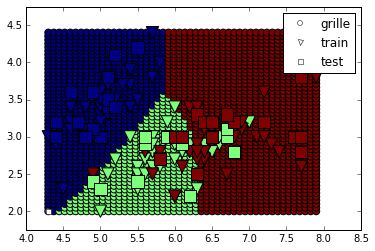

In [6]:
# Deuxième test: uniquement les colonnes 0 et 1
train_cols = [0,1]

# On cree un modele par classe (par maximum de vraissemblance)
model_classe1=gauss_mv(len(train_cols))
model_classe2=gauss_mv(len(train_cols))
model_classe3=gauss_mv(len(train_cols))
model_classe1.train(iris_train1[:,train_cols])
model_classe2.train(iris_train2[:,train_cols])
model_classe3.train(iris_train3[:,train_cols])

# On cree une liste de tous nos modeles
# On fait la meme chose pour les priors
# Les priors sont calcules ici de facon exact car on connait le nombre 
# de representants par classes. Un fois que vous aurez cree un
# ensemble de train/test, il va faloir les calculer de facon exacte
modele_mv=[model_classe1,model_classe2,model_classe3]
priors=[0.3333,0.3333,0.3333]

# On cree notre classifieur avec notre liste de modeles gaussien et nos priors
classifieur=classif_bayes(modele_mv,priors)

#on peut maintenant calculer les logs-probabilites selon nos modeles
log_prob_train=classifieur.compute_predictions(iris_train[:, train_cols])
log_prob_test=classifieur.compute_predictions(iris_test[:, train_cols])

# il reste maintenant a calculer le maximum par classe pour la classification
classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

utilitaires.gridplot(classifieur,
                     iris_train[:, train_cols + [-1]],
                     iris_test[:, train_cols + [-1]],
                     n_points=50)

## Si vous avez terminé

 - Modifiez votre code pour que `gauss_mv` calcule une matrice de covariance diagonale (où l'on estime la variance pour chaque composante/trait de l'entrée) ou même une matrice de covariance pleine.
 - Les commandes `numpy.cov` et `numpy.var` vous seront probablement utiles.

In [7]:
# Premier test: avec toutes les colonnes
train_cols = [0,1,2,3]

for cov_type in ['isotropique','diagonale','full']:
    # On cree un modele par classe (par maximum de vraissemblance)
    model_classe1=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe2=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe3=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe1.train(iris_train1[:,train_cols])
    model_classe2.train(iris_train2[:,train_cols])
    model_classe3.train(iris_train3[:,train_cols])
    
    # On cree une liste de tous nos modeles
    # On fait la meme chose pour les priors
    # Les priors sont calcules ici de facon exact car on connait le nombre 
    # de representants par classes. Un fois que vous aurez cree un
    # ensemble de train/test, il va faloir les calculer de facon exacte
    modele_mv=[model_classe1,model_classe2,model_classe3]
    priors=[0.3333,0.3333,0.3333]

   # On cree notre classifieur avec notre liste de modeles gaussien et nos priors
    classifieur=classif_bayes(modele_mv,priors)
    
    #on peut maintenant calculer les logs-probabilites selon nos modeles
    log_prob_train=classifieur.compute_predictions(iris_train[:, train_cols])
    log_prob_test=classifieur.compute_predictions(iris_test[:, train_cols])
    
    # il reste maintenant a calculer le maximum par classe pour la classification
    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    
    print cov_type
    print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
    print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)


isotropique
Taux d'erreur (entrainement) 4.76%
Taux d'erreur (test) 8.89%
diagonale
Taux d'erreur (entrainement) 4.76%
Taux d'erreur (test) 2.22%
full
Taux d'erreur (entrainement) 1.90%
Taux d'erreur (test) 6.67%


isotropique
Taux d'erreur (entrainement) 3.81%
Taux d'erreur (test) 4.44%


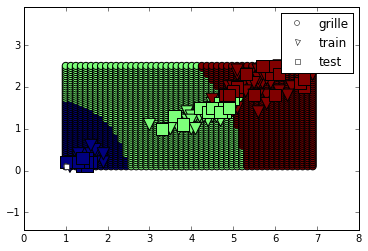

diagonale
Taux d'erreur (entrainement) 3.81%
Taux d'erreur (test) 2.22%


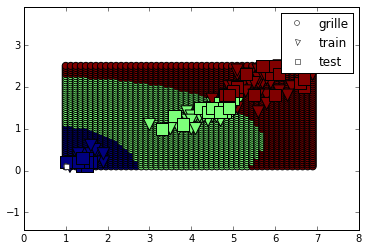

full
Taux d'erreur (entrainement) 1.90%
Taux d'erreur (test) 2.22%


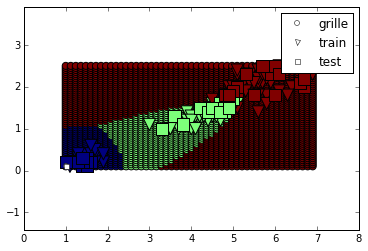

In [8]:
# Deuxième test: uniquement les colonnes 2 et 3
train_cols = [2,3]

for cov_type in ['isotropique','diagonale','full']:
    # On cree un modele par classe (par maximum de vraissemblance)
    model_classe1=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe2=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe3=gauss_mv(len(train_cols),cov_type=cov_type)
    model_classe1.train(iris_train1[:,train_cols])
    model_classe2.train(iris_train2[:,train_cols])
    model_classe3.train(iris_train3[:,train_cols])
    
    # On cree une liste de tous nos modeles
    # On fait la meme chose pour les priors
    # Les priors sont calcules ici de facon exact car on connait le nombre 
    # de representants par classes. Un fois que vous aurez cree un
    # ensemble de train/test, il va faloir les calculer de facon exacte
    modele_mv=[model_classe1,model_classe2,model_classe3]
    priors=[0.3333,0.3333,0.3333]

   # On cree notre classifieur avec notre liste de modeles gaussien et nos priors
    classifieur=classif_bayes(modele_mv,priors)
    
    #on peut maintenant calculer les logs-probabilites selon nos modeles
    log_prob_train=classifieur.compute_predictions(iris_train[:, train_cols])
    log_prob_test=classifieur.compute_predictions(iris_test[:, train_cols])
    
    # il reste maintenant a calculer le maximum par classe pour la classification
    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    
    print cov_type
    print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
    print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

    utilitaires.gridplot(classifieur,
                         iris_train[:, train_cols + [-1]],
                         iris_test[:, train_cols + [-1]],
                         n_points=50)